In [2]:
import os, sys
from glob import glob
import numpy as np
import xarray as xr
import pandas as pd
from glob import glob
import proplot as plot
import cartopy.crs as ccrs
from netCDF4 import Dataset
import matplotlib as mpl
from datetime import datetime, timedelta
from proplot.colors import LinearSegmentedColormap
from wrf import (to_np, getvar, extract_vars, ALL_TIMES,
                 CoordPair, vertcross, interplevel,
                 omp_set_num_threads, omp_get_num_procs)
from pycwr.core.transforms import geographic_to_cartesian_aeqd

In [3]:
# load personal functions
sys.path.append('../scripts/')

from radar import cnradar
from xin_cartopy import load_province, add_grid
# from wrfchem import read_wrf
provinces  = load_province()

# load cmaps
pyart_dbz = LinearSegmentedColormap.from_file('../data/cmaps/pyart_dbz.json').reversed()

## Pair radar data with wrfout* files

### Set basic parameters

In [75]:
# date to plot the fig
date = '20200901' # 20190725 or 20200901

# basic info for both data
radar_dir = f'../data/radar/{date}/'
wrf_dir = f'../data/wrfchem/wrfout/{date}/'

# offset to find the paired wrfout* files
if date == '20190725':
    offset = [timedelta(minutes=60)]*3 # minutes
else:
    offset = [timedelta(minutes=30)]*3 # minutes
#     offset = [timedelta(minutes=30), timedelta(minutes=30), timedelta(minutes=60)] # minutes
    
if date == '20190725':
    # picked radar times (HHMM)
    times = ['0416', '0537', '0649']
    # region for plot
    extend = [118.5, 119.5, 31.5, 32.5]
    # tick space
    lon_d = 0.25; lat_d = 0.25

    # start points and end points for crosslines
    # crossline for comparing the vertical structure of convection
#     a = [118.85, 31.92]
#     b = [119.38, 32.37]
    a = [118.85, 31.82]
    b = [119.38, 32.27]

    # # crossline for checking what ??????
    c = [118.875, 32]
    d = [119, 31.5]

    # rectangle for focused region of ozonesonde
#     rec_center = (118.95, 31.92)
#     rec_width = 0.2
#     rec_height = 0.08
    rec_center = (118.98, 31.9)
    rec_width = 0.15
    rec_height = 0.1


else:
    times = ['0446', '0548', '0638']
    extend = [118.2, 119.8, 31.2, 32.8]
    lon_d = 0.5; lat_d = 0.5
    a = [118.55, 31.85]
    b = [119, 32.2]
#     rec_center = (118.75, 31.9)
#     rec_width = 0.2
#     rec_height = 0.1
    rec_center = (118.7, 31.87)
    rec_width = 0.15
    rec_height = 0.1

### Generate the time range

### Generate the radar file list based on `times`

In [76]:
radar_files = [file for file in sorted(os.listdir(radar_dir)) if file.split('_')[4][8:12] in times]
radar_files

['Z_RADR_I_Z9250_20200901044600_O_DOR_SA_CAP.bin.bz2',
 'Z_RADR_I_Z9250_20200901054800_O_DOR_SA_CAP.bin.bz2',
 'Z_RADR_I_Z9250_20200901063800_O_DOR_SA_CAP.bin.bz2']

### Generate the paired time for wrfout* files

In [77]:
time_range = pd.to_datetime(sorted(['_'.join(file.split('_')[2:4])
                                    for file in os.listdir(wrf_dir)
                                    if file.startswith('wrfout')]),
                            format='%Y-%m-%d_%H:%M:%S')

wrf_time = []
for index,radar_name in enumerate(radar_files):
    radar_time = datetime.strptime(radar_name.split('_')[4], '%Y%m%d%H%M%S')
    # https://stackoverflow.com/questions/42264848/
    #      pandas-dataframe-how-to-query-the-closest-datetime-index
    nearest_index = time_range.get_loc(radar_time, method='nearest')
    wrf_time.append(time_range[nearest_index]-offset[index])

## Read wrfout* files

In [78]:
wrf_files = [t.strftime(f'{wrf_dir}wrfout_*_%Y-%m-%d_%H:%M:%S*') for t in wrf_time]
wrf_in = [Dataset(glob(x)[0]) for x in wrf_files]

### Create cache

In [79]:
my_cache = extract_vars(wrf_in,
                        ALL_TIMES,
                        ("T", "P", "PB", "QVAPOR", "QRAIN")
                        )   
omp_set_num_threads(omp_get_num_procs())
mdbz = getvar(wrf_in, 'mdbz', timeidx=ALL_TIMES, cache=my_cache)

## Define the axis function

In [80]:
def set_axis(nrows=2, ncols=3):
    '''set axis based on number of rows and cols'''
    f, axs = plot.subplots(proj='eqc',
                           nrows=nrows,
                           ncols=ncols,
                           span=3,
                           share=3)

    rowlabels = ['OBS', 'WRF-Chem']
    collabels = ['Initiation', 'TROPOMI pass time', 'Ozonesonde launch time']

    axs.format(rowlabels=rowlabels,
               collabels=collabels,
               dms=False,
               abc=True,
               abcloc='ul',
               abcstyle='(a)',
               #labels=True,
               lonlines=lon_d,
               latlines=lat_d,
               lonlim=(extend[0], extend[1]),
               latlim=(extend[2], extend[3]),
               gridlinewidth=1,
              )

    axs[:, 0].format(latlabels=True)
    axs[-1, :].format(lonlabels=True)

    axs.add_feature(provinces, edgecolor='k', linewidth=.3)

    return axs, f

## Define function of plotting mdbz

In [81]:
def plot_data(axs, f, index,
              radar, mdbz, levels):
    '''plot mdbz for radar and wrfchem data at the same time'''
    ax_index = index
    ax = axs[ax_index]
#     st = np.datetime_as_string(radar.st, unit='s')
#     title = st.replace('T', ' ')

    m = ax.contourf(radar.crf_lon,
                    radar.crf_lat,
                    radar.crf,
                    cmap=pyart_dbz,
                    levels=levels,
                     )
#     ax.format(title=title)#, share=3)
    ax.format(title=(wrf_time[index]+offset[index]).strftime('%Y-%m-%d %H:%M'))

    # bottom column for chem
    ax = axs[ax_index+3]
    m = ax.contourf(mdbz.coords['XLONG'],
                    mdbz.coords['XLAT'],
                    mdbz[index, :, :],
                    cmap=pyart_dbz,
                    levels=levels,
                    )
    ax.format(title=wrf_time[index].strftime('%Y-%m-%d %H:%M'))#, share=3)
    #ax.format(title='', share=3)

    return m

## Define function of adding crossline

In [82]:
def add_crossline(spoint, epoint, stext, etext, axs):
    '''Add crossline and texts'''
    for ax in axs:
        # add text annotation
        ax.text(spoint[0]-0.05, spoint[1]-0.05, stext, transform=ccrs.PlateCarree(), fontweight='bold')
        ax.text(epoint[0]+0.02, epoint[1]+0.02, etext, transform=ccrs.PlateCarree(), fontweight='bold')
    
        ax.plot(
                 [spoint[0], epoint[0]],
                 [spoint[1], epoint[1]],
                 color='gray9',
                 transform=ccrs.PlateCarree()
                 )  

/home/xin/miniconda3/envs/python37/lib/python3.8/site-packages/pycwr-0.2.15-py3.8-linux-x86_64.egg/pycwr/core/NRadar.py:235: RuntimeWarning: All-NaN slice encountered
  GridV = get_CR_xy(vol_azimuth, vol_range, fix_elevation, vol_value, \
/home/xin/miniconda3/envs/python37/lib/python3.8/site-packages/pycwr-0.2.15-py3.8-linux-x86_64.egg/pycwr/core/NRadar.py:235: RuntimeWarning: All-NaN slice encountered
  GridV = get_CR_xy(vol_azimuth, vol_range, fix_elevation, vol_value, \
/home/xin/miniconda3/envs/python37/lib/python3.8/site-packages/pycwr-0.2.15-py3.8-linux-x86_64.egg/pycwr/core/NRadar.py:235: RuntimeWarning: All-NaN slice encountered
  GridV = get_CR_xy(vol_azimuth, vol_range, fix_elevation, vol_value, \
/home/xin/miniconda3/envs/python37/lib/python3.8/site-packages/proplot/figure.py:1158: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  

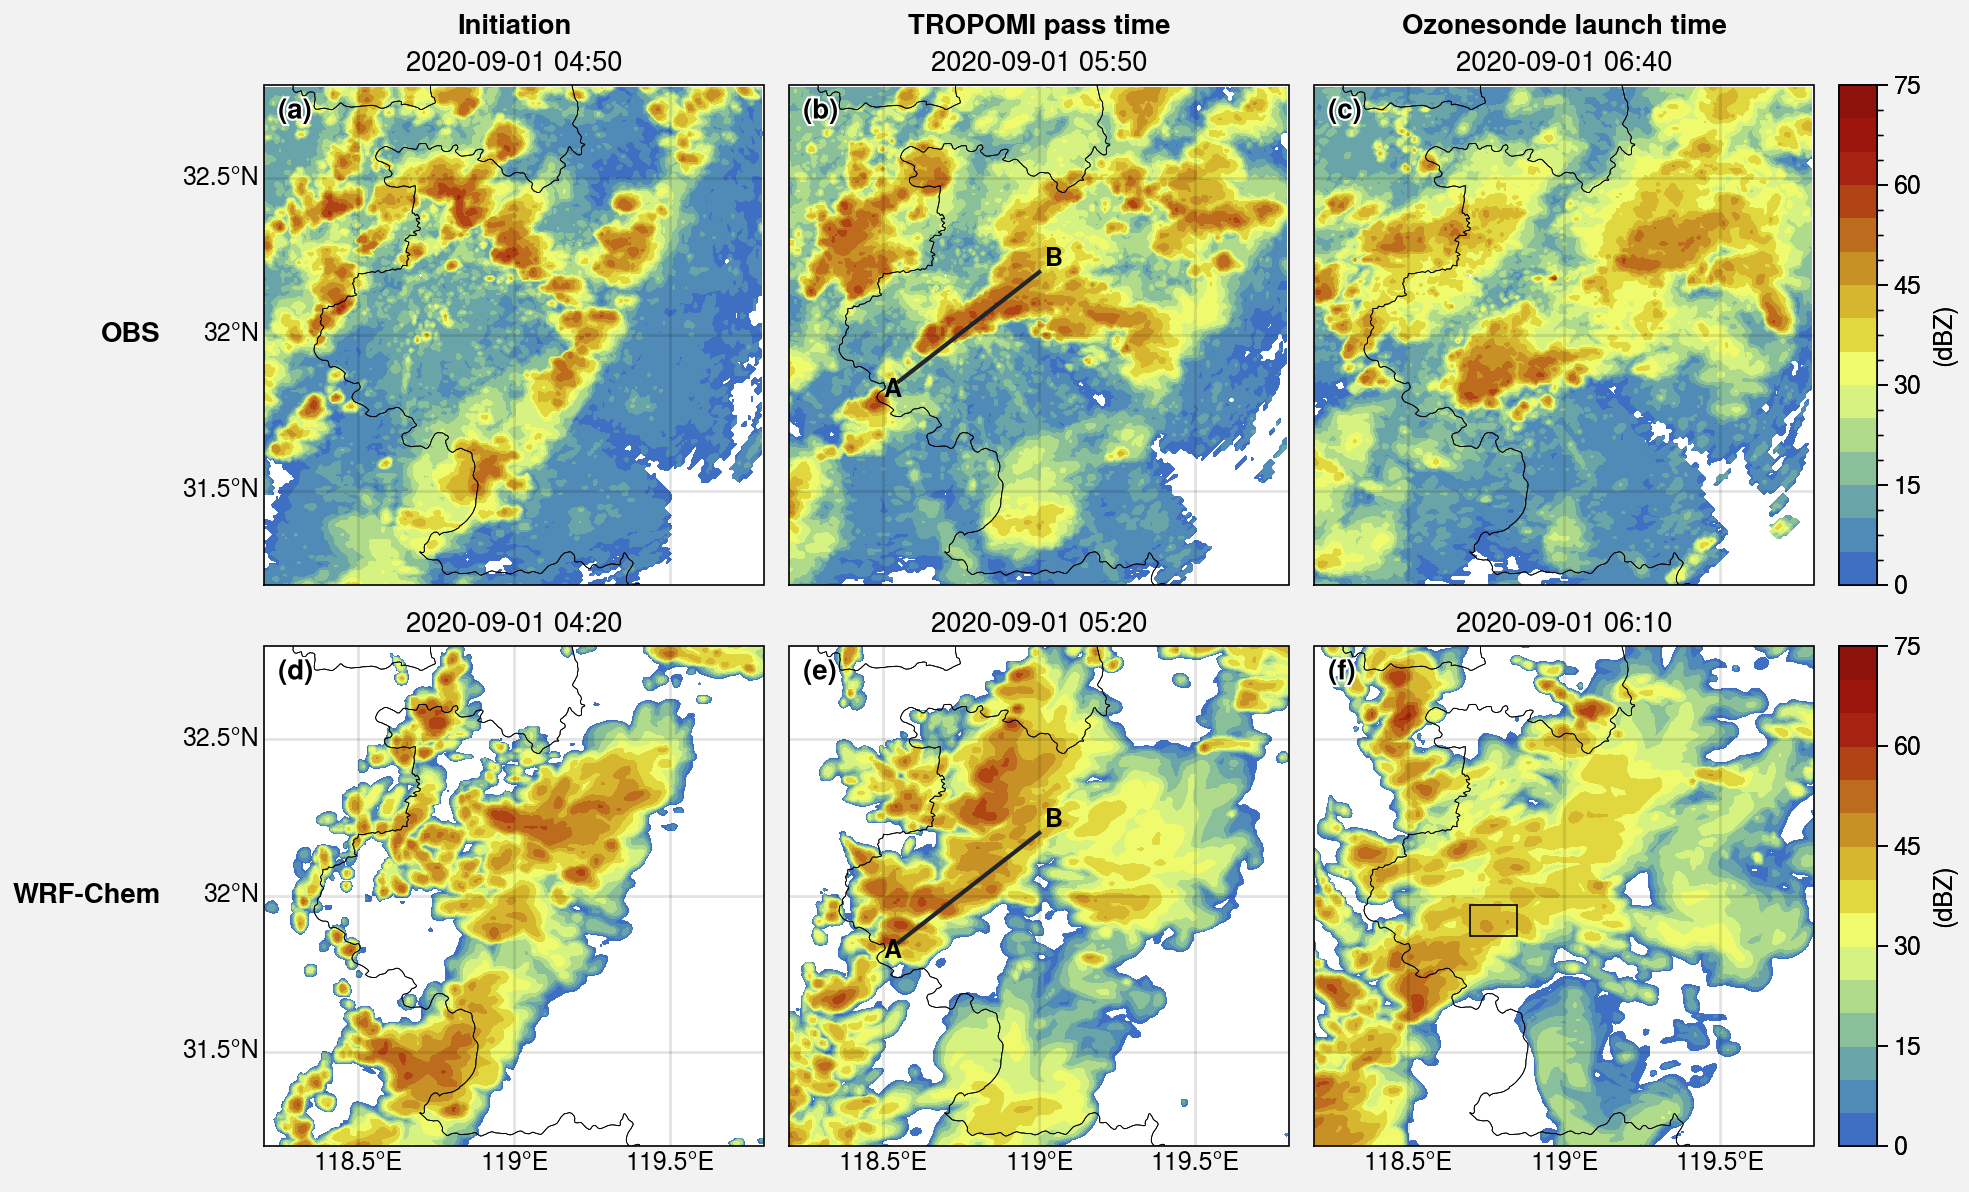

In [83]:
axs, f = set_axis()
levels = np.linspace(0, 75, 16)
for index,file in enumerate(radar_files):
    radar = cnradar(radar_dir+file, extend=extend)
    m = plot_data(axs, f, index, radar,
                  mdbz, levels)

# add colorbar
f.colorbar(m, label='(dBZ)', loc='r', row=1, ticks=levels[::3])
f.colorbar(m, label='(dBZ)', loc='r', row=2, ticks=levels[::3])

# add arrows
arrow_properties = dict(
    facecolor='white',
    edgecolor='white',
    width=0.5,
    headwidth=4, shrink=0.1)

# # add arrow for target
# axs[1].annotate('', xy=(118.8, 32),
#                 xytext=(118.9, 31.85),
#                 arrowprops=arrow_properties,
#                 color='white'
#                 )

# add crosssection line (AB)
stext = 'A'
etext = 'B'
add_axs = [axs[1], axs[4]]
add_crossline(a, b, stext, etext, add_axs)


# ## add crosssection line (CD)
# # check the active area in specific region (south)
# stext = 'C' 
# etext = 'D' 
# add_crossline(c, d, stext, etext, [axs[4]])


# add rectangle for focused region of ozonesonde
axs[5].add_patch(mpl.patches.Rectangle(rec_center,
                                       rec_width,
                                       rec_height,
                                       fill=None,
                                       edgecolor='black'))

# save figure
f.savefig(f'../figures/comp_crf_{date[:4]}.png')

## Plot cross section

### Read specific data for cross section

In [84]:
radar_cross = cnradar(radar_dir+radar_files[1], extend=extend)
wrf_cross = Dataset(glob(wrf_files[1])[0])
glob(wrf_files[1])[0]

/home/xin/miniconda3/envs/python37/lib/python3.8/site-packages/pycwr-0.2.15-py3.8-linux-x86_64.egg/pycwr/core/NRadar.py:235: RuntimeWarning: All-NaN slice encountered
  GridV = get_CR_xy(vol_azimuth, vol_range, fix_elevation, vol_value, \


'../data/wrfchem/wrfout/20200901/wrfout_d04_2020-09-01_05:20:00_subset'

In [85]:
# get height and dbz variables
z = getvar(wrf_cross, 'z', units='km')
dbz = getvar(wrf_cross, "dbz")
Z = 10**(dbz/10.)

### Interpolate wrf data to heights and crossline

In [86]:
z_levels = np.linspace(0, 15, 61)
z_cross = vertcross(Z, z, wrfin=wrf_cross,
                    levels = z_levels,
                    start_point=CoordPair(lon=a[0], lat=a[1]),
                    end_point=CoordPair(lon=b[0], lat=b[1]),
                    latlon=True, meta=True)
dbz_cross = 10.0 * np.log10(z_cross)

### Interpolate radar data

In [87]:
lon_0 = radar.radar.scan_info.longitude.values
lat_0 = radar.radar.scan_info.latitude.values
start_x, start_y = geographic_to_cartesian_aeqd(lat=a[1],
                                                lon=a[0],
                                                lat_0=lat_0,
                                                lon_0=lon_0)
end_x, end_y = geographic_to_cartesian_aeqd(lat=b[1],
                                            lon=b[0],
                                            lat_0=lat_0,
                                            lon_0=lon_0)

mesh_xy, mesh_z, field_data = radar_cross.radar.get_vcs_data((start_x[0], start_y[0]),
                                                             (end_x[0], end_y[0]),
                                                             'dBZ')

## Plot data

/home/xin/miniconda3/envs/python37/lib/python3.8/site-packages/proplot/axes/plot.py:2955: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  obj = func(self, *args, **kwargs)


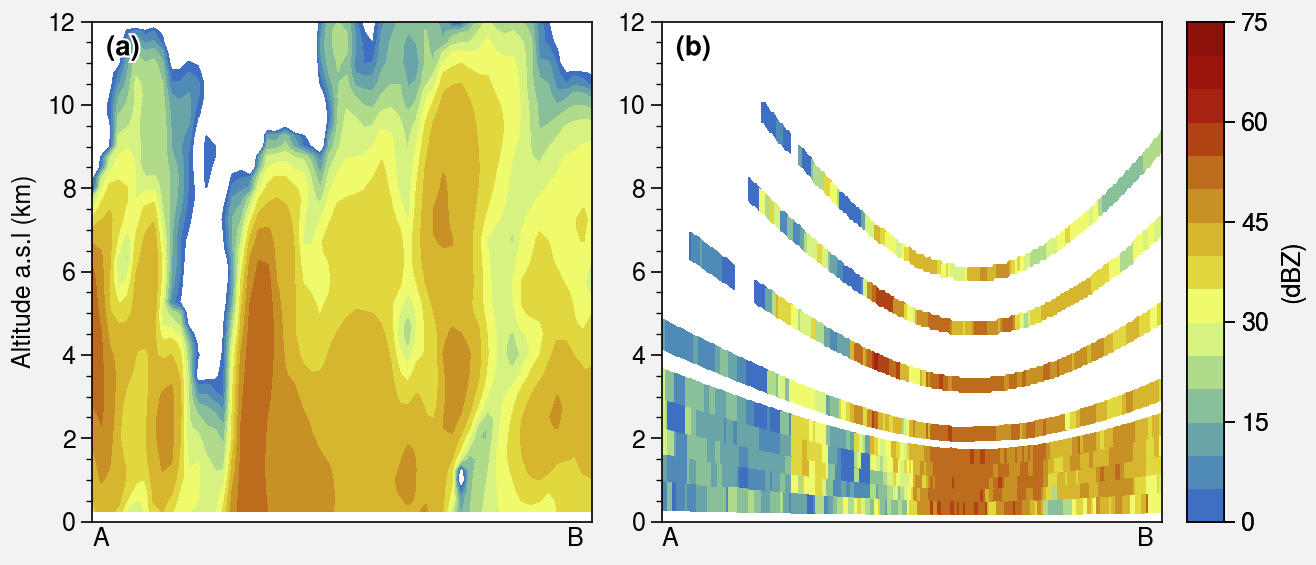

In [88]:
f, axs = plot.subplots(ncols=2, share=0)
axs.format(grid=False)

levels = np.linspace(0, 75, 16)

# --- WRF part ---
ax = axs[0]
dbz_contours = ax.contourf(dbz_cross.cross_line_idx,
                           dbz_cross.vertical,
                           to_np(dbz_cross),
                           cmap=pyart_dbz,
                           levels=levels,
                           )
ax.format(ylabel='Altitude a.s.l (km)')

# --- Radar part ---
ax = axs[1]
for isweep, _ in enumerate(mesh_xy):
    gci = ax.pcolormesh(mesh_xy[isweep] / 1000.,
                        mesh_z[isweep] / 1000.,
                        field_data[isweep],
                        cmap=pyart_dbz,
                        levels=levels)

# ax.format(ylim=(0, 12), yticks=plot.arange(0, 12, 2))
axs.format(xlocator='null',
           xlabel='',
           ylim=(0, 12),
           yticks=plot.arange(0, 12, 2),
           abc=True,
           abcloc='ul',
           abcstyle='(a)',
           )

# add annotation
for ax in axs:
    ax.text(0, -0.05,
            'A',
            transform=ax.transAxes)

    ax.text(0.95, -0.05,
            'B',
            transform=ax.transAxes)

# add colorbar
f.colorbar(gci,
           loc='r',
           label='(dBZ)',
           ticks=levels[::3]
           )

# save figure
f.savefig(f'../figures/comp_dbzcross_{date[:4]}.png')